In [1]:
!pip install timm

  Using cached timm-1.0.8-py3-none-any.whl.metadata (53 kB)
  Using cached huggingface_hub-0.24.6-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached timm-1.0.8-py3-none-any.whl (2.3 MB)
Using cached huggingface_hub-0.24.6-py3-none-any.whl (417 kB)
Using cached safetensors-0.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (435 kB)

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import os
import timm  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to create dataloaders for train, validation, and test sets
def create_dataloaders(base_dir, batch_size=64):
    transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Xception typically uses 299x299 input size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Slightly rotate the image, up to ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Slight translation to simulate small camera movements
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
    val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'validate'), transform=transform)
    test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

# Xception-based binary classifier model
class XceptionBinaryClassifier(nn.Module):
    def __init__(self):
        super(XceptionBinaryClassifier, self).__init__()
        self.model = timm.create_model('legacy_xception', pretrained=True)  # Load pre-trained Xception model
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.get_classifier().in_features, 1),
            nn.BatchNorm1d(1),  # Add BatchNorm after the linear layer
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


Epoch 1/10, Train Loss: 0.6785, Train Acc: 60.91%, Val Loss: 0.8020, Val Acc: 48.11%
Epoch 2/10, Train Loss: 0.5458, Train Acc: 73.69%, Val Loss: 0.7588, Val Acc: 51.17%
Epoch 3/10, Train Loss: 0.4841, Train Acc: 80.03%, Val Loss: 0.7252, Val Acc: 54.94%
Epoch 4/10, Train Loss: 0.4439, Train Acc: 84.98%, Val Loss: 0.6974, Val Acc: 55.42%
Epoch 5/10, Train Loss: 0.4201, Train Acc: 87.74%, Val Loss: 0.6966, Val Acc: 57.09%
Epoch 6/10, Train Loss: 0.4004, Train Acc: 90.77%, Val Loss: 0.6765, Val Acc: 59.43%
Epoch 7/10, Train Loss: 0.3842, Train Acc: 92.13%, Val Loss: 0.6803, Val Acc: 59.71%
Epoch 8/10, Train Loss: 0.3758, Train Acc: 93.39%, Val Loss: 0.6703, Val Acc: 60.54%
Epoch 9/10, Train Loss: 0.3667, Train Acc: 94.36%, Val Loss: 0.6525, Val Acc: 62.72%
Epoch 10/10, Train Loss: 0.3599, Train Acc: 95.04%, Val Loss: 0.6583, Val Acc: 62.45%


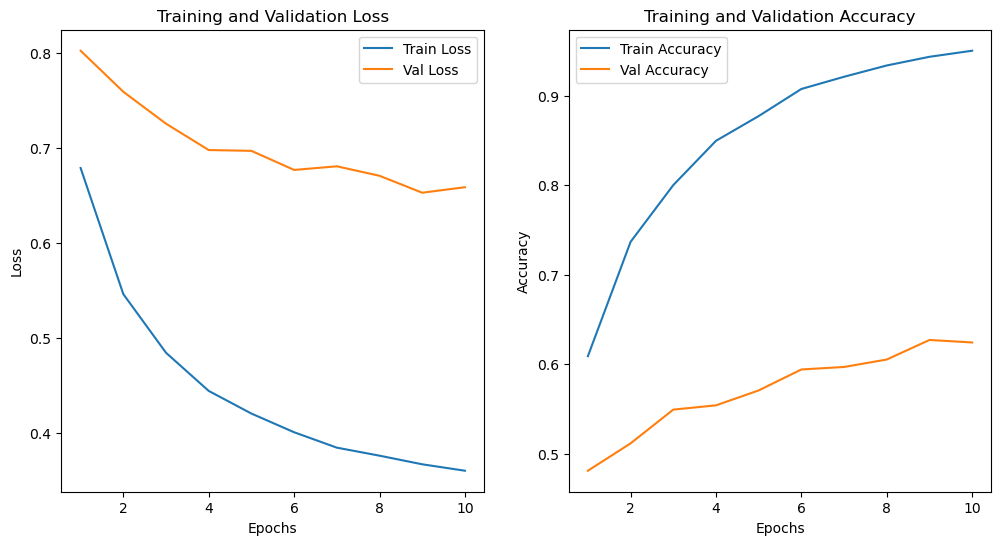

Accuracy on test set: 75.49%
Confusion Matrix:


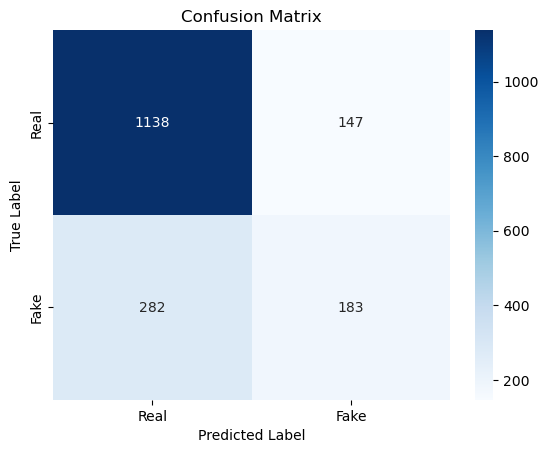

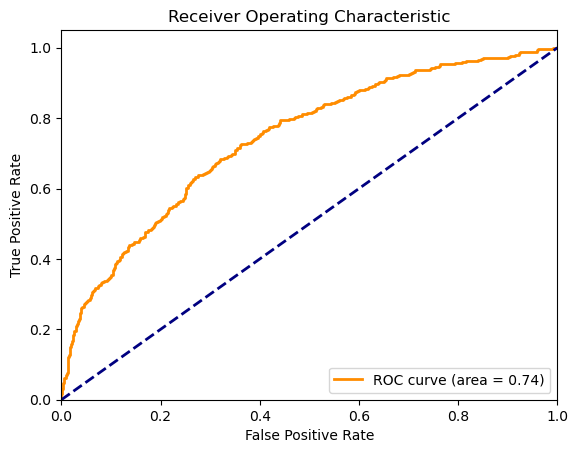

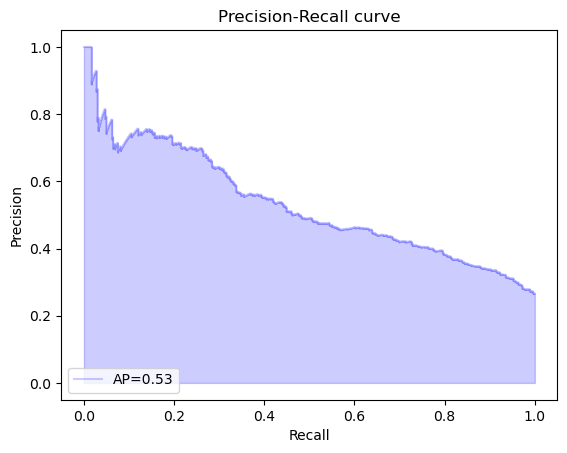

In [27]:
def train_model(model, train_loader, val_loader, epochs=10, device=device):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
    criterion = nn.BCELoss()
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            predicted = torch.round(outputs)
            correct += (predicted.squeeze() == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy, _, _ = evaluate_model(model, val_loader, device, is_train=False)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")
    
    # Plotting
    epochs_range = range(1, epochs + 1)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.show()


# Evaluation function
def evaluate_model(model, data_loader, device, is_train=True):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # To store probabilities for ROC and Precision-Recall curves
    running_loss = 0.0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = torch.round(outputs)
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())
            y_scores.extend(outputs.cpu().tolist())


    accuracy = accuracy_score(y_true, y_pred)
    avg_loss = running_loss / len(data_loader)
    
    if is_train:
        print(f"Accuracy on test set: {accuracy * 100:.2f}%")
        print("Confusion Matrix:")
        plot_confusion_matrix(y_true, y_pred)
        

    return avg_loss, accuracy, y_true, y_scores

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure()
    plt.step(recall, precision, where='post', color='b', alpha=0.2, label='AP={0:0.2f}'.format(average_precision))
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower left")
    plt.show()

# Training script
base_dir = '/home/jovyan/DeepFakeDetection/Celeb-DF/Data/'
train_loader, val_loader, test_loader = create_dataloaders(base_dir)
model = XceptionBinaryClassifier()
train_model(model, train_loader, val_loader, device=device)

# Final evaluation on the test set
test_loss, test_accuracy, y_true, y_score = evaluate_model(model, test_loader, device, is_train=True)


plot_roc_curve(y_true, y_score)
plot_precision_recall_curve(y_true, y_score)

In [28]:
import torch

# Saving the trained model
torch.save(model.state_dict(), 'basic_model.pth')
print("Model saved successfully!")


Model saved successfully!


In [11]:
import torch
from torchvision import transforms
from PIL import Image

# Loading the trained model
model = XceptionBinaryClassifier()
model.load_state_dict(torch.load('basic_model.pth')) 
model.eval()  


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


transform = transforms.Compose([
    transforms.Resize((299, 299)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def preprocess_image(image_path):
    # Loading and preprocessing the image
    image = Image.open(image_path).convert('RGB')  
    image = transform(image).unsqueeze(0)  
    return image.to(device)  

def classify_image(image_path):
    image = preprocess_image(image_path)
    
    
    with torch.no_grad():
        output = model(image)
        prediction = torch.round(output).item()  

    
    if prediction == 1.0:
        print("The image is classified as: Real")
    else:
        print("The image is classified as: Fake")


image_path = '/home/jovyan/DeepFakeDetection/Celeb-DF/ImageFake.png'  
classify_image(image_path)


The image is classified as: Fake
